In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import yaml
import json
import seaborn as sns

In [3]:
def read_run(run, experiment):
  data = {}
  with open(run / "files" / "config.yaml") as fp:
    config = yaml.load(fp, yaml.SafeLoader)
    if not config["experiment"]["value"] == experiment:
      return {}
    for k in ["a", "b", "c", "d", "ssm_act"]:
      val = config[f"{k}_bits"]["value"]
      data[k] = val if val is not None else -1
    data["tau"] = int(config["tau"]["value"][4:])
  with open(run / "files" / "wandb-summary.json") as fp:
    json_data = json.load(fp)
    if "Best Val Loss" not in json_data:
      return {}
    data["loss"] = json_data["Best Val Loss"]
  return data

read_run(Path("wandb/run-20240524_052234-f9iusgu6"), "mackey_glass")

{}

In [4]:
runs = list(Path("wandb").glob("run-*"))
run_data = [read_run(x, "mackey_glass") for x in runs]
df = pd.DataFrame(run_data).dropna()
df.head()

,a,b,c,d,ssm_act,tau,loss
0,-1.0,-1.0,-1.0,-1.0,6.0,225.0,34.634060
1,5.0,-1.0,-1.0,-1.0,-1.0,209.0,37.781586
2,8.0,-1.0,-1.0,-1.0,-1.0,97.0,35.263592
3,3.0,-1.0,-1.0,-1.0,-1.0,225.0,53.409946
4,5.0,-1.0,-1.0,-1.0,-1.0,113.0,37.555450


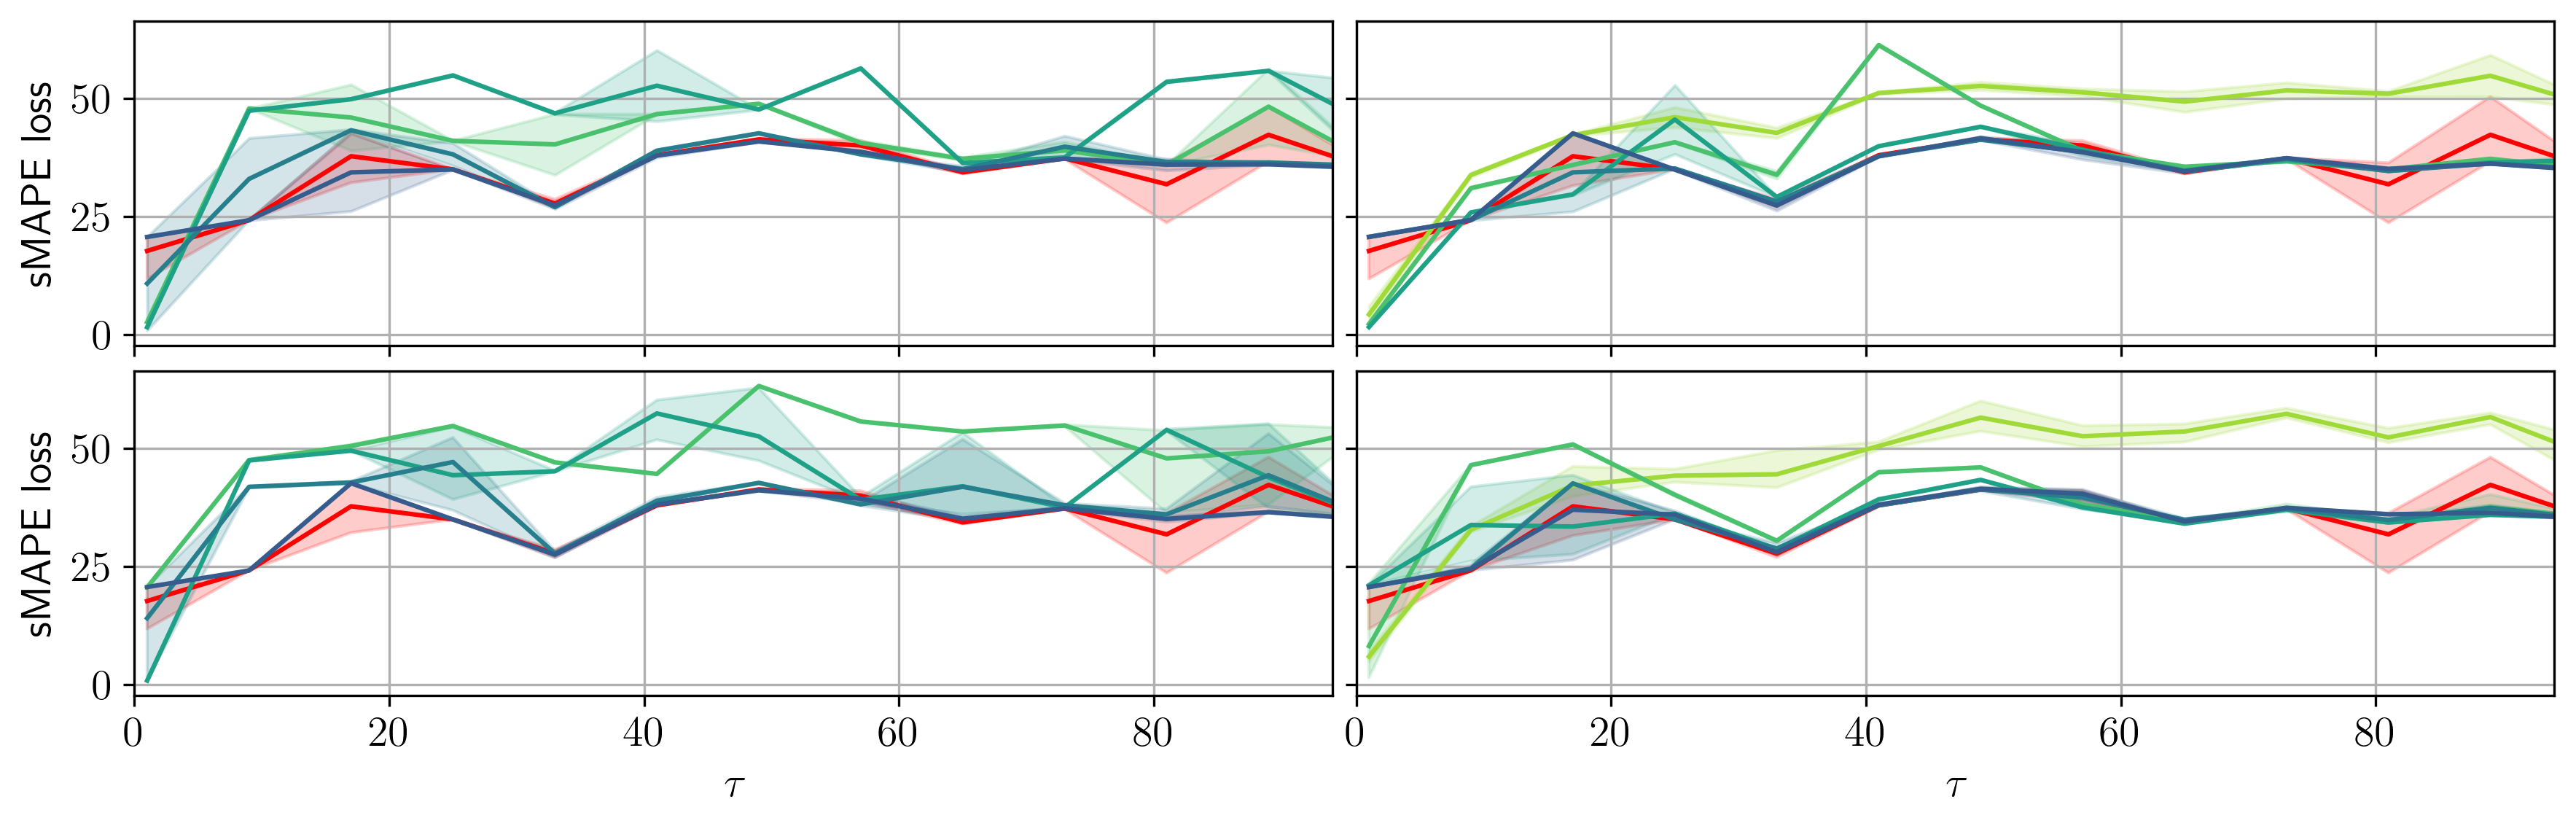

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "CMU Sans Serif",
    "font.size": 14
})

order = [-1, 1, 2, 4, 8, 16]
# palette = list(sns.color_palette("rocket", 10))
palette = sns.color_palette("viridis_r", len(order))
palette = ["red"] + palette[:-1]
labels = ["fp32"] + order
f, ((a1, a2), (a3, a4)) = plt.subplots(2, 2, figsize=(12, 4), dpi=300, sharey=True, sharex=True)

# Plot 1: Everything quantized
ax = a1
df_all = df[(df["a"] == df["b"]) & (df["b"] == df["c"]) & (df["c"] == df["d"]) & (df["d"] == df["ssm_act"]) & (df["loss"] < 10000)]
sns.lineplot(df_all, x="tau", y="loss", hue="a", palette=palette, ax=ax, hue_order=order, legend=False)
# a4.get_legend().set_title("Activation bits")
# a4.get_legend().texts[0].set_text("fp32")
# ax.set_title("WxAx$\\Lambda$x")

# Plot 2: A quantized
ax = a2
df_a = df[(df["a"] == -1) & (df["b"] == df["c"]) & (df["c"] == df["d"]) & (df["d"] == df["ssm_act"]) & (df["loss"] < 10000)]
sns.lineplot(df_a, x="tau", y="loss", hue="ssm_act", palette=palette, ax=ax, hue_order=order, legend=False)
# a3.get_legend().set_title("Activation bits")
# a3.get_legend().texts[0].set_text("fp32")
# ax.set_title("WxAf$\\Lambda$x")

# Plot 3: A vs tau
ax = a3
df_tau = df[(df["b"] == -1) & (df["d"] == -1)& (df["d"] == -1) & (df["ssm_act"] == -1) & (df["loss"] < 10000)]
# df_tau = df_tau.groupby(["a", "tau"]).mean().reset_index()
sns.lineplot(df_tau, x="tau", y="loss", hue="a", palette=palette, ax=ax, hue_order=order, legend=False)
# a1.get_legend().set_title("A bits")
# a1.get_legend().texts[0].set_text("fp32")
# ax.set_title("WfAx$\\Lambda$f")

# Plot 4: Activation vs tau
ax = a4
df_act = df[(df["b"] == -1) & (df["d"] == -1)& (df["d"] == -1) & (df["a"] == -1) & (df["loss"] < 10000)]
sns.lineplot(df_act, x="tau", y="loss", hue="ssm_act", palette=palette, ax=ax, hue_order=order, legend=False)
# a2.get_legend().set_title("Activation bits")
# a2.get_legend().texts[0].set_text("fp32")
# ax.set_title("Activation quantization only")

for a in [a1, a2, a3, a4]:
  a.set_xlim(0, 94)
  a.set_ylabel("sMAPE loss")
  a.set_xlabel(r"$\tau$")
  a.grid(True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.08, wspace=0.02)

Text(39.01277430555556, 0.5, 'sMAPE loss')

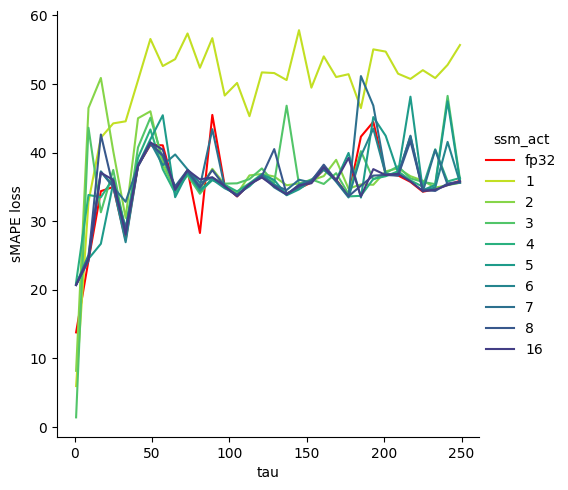

In [7]:
df_act = df[(df["b"] == -1) & (df["d"] == -1)& (df["d"] == -1) & (df["a"] == -1) & (df["loss"] < 10000)]
df_act = df_act.groupby(["tau", "ssm_act"]).mean().reset_index()
palette = sns.color_palette("viridis_r", 10)
palette = ["red"] + palette[:-1]
labels = ["fp32"] + [f"{float(x):.0f}" for x in df_act["ssm_act"].unique()][1:]
ax = sns.relplot(df_act, x="tau", y="loss", kind="line", hue="ssm_act", palette=palette)
for t, l in zip(ax.legend.texts, labels):
    t.set_text(l)
ax.ax.set_ylabel("sMAPE loss")

<Axes: xlabel='a', ylabel='tau'>

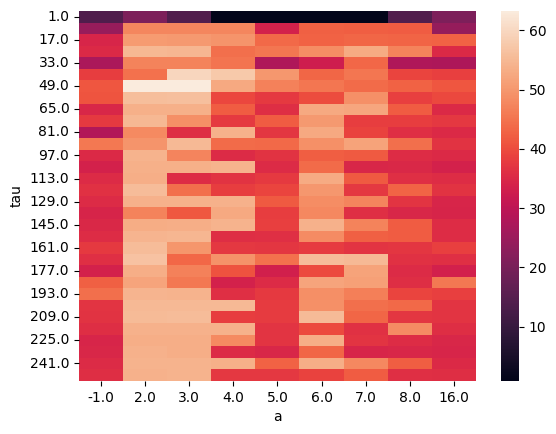

In [8]:
df_tau = df[(df["b"] == -1) & (df["d"] == -1)& (df["d"] == -1) & (df["ssm_act"] == -1) & (df["loss"] < 10000)]
df_tau_pivot = df_tau.pivot_table(index="tau", columns="a", values="loss")
sns.heatmap(df_tau_pivot)

In [113]:
df[(df["a"] == -1) & (df["b"] == -1)& (df["d"] == -1)& (df["d"] == -1)]

,a,b,c,d,ssm_act,tau,loss
1,-1.0,-1.0,-1.0,-1.0,2.0,233.0,35.082073
2,-1.0,-1.0,-1.0,-1.0,6.0,1.0,20.774975
4,-1.0,-1.0,-1.0,-1.0,6.0,49.0,41.411385
5,-1.0,-1.0,-1.0,-1.0,2.0,177.0,34.232624
6,-1.0,-1.0,-1.0,-1.0,1.0,49.0,53.663971
...,...,...,...,...,...,...,...
659,-1.0,-1.0,-1.0,-1.0,1.0,129.0,52.851940
667,-1.0,-1.0,-1.0,-1.0,2.0,81.0,34.515503
668,-1.0,-1.0,-1.0,-1.0,8.0,113.0,35.228645
670,-1.0,-1.0,-1.0,-1.0,16.0,121.0,36.220284


(0.0, 100.0)

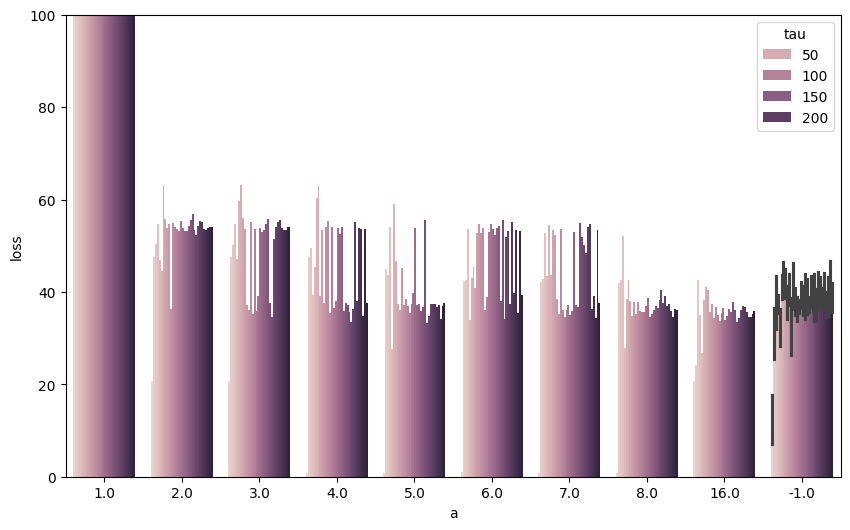

In [145]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x="a", y="loss", order=sorted(df["a"].unique())[1:] + [-1], hue="tau")
ax.set_ylim(0, 100)

(0.0, 100.0)

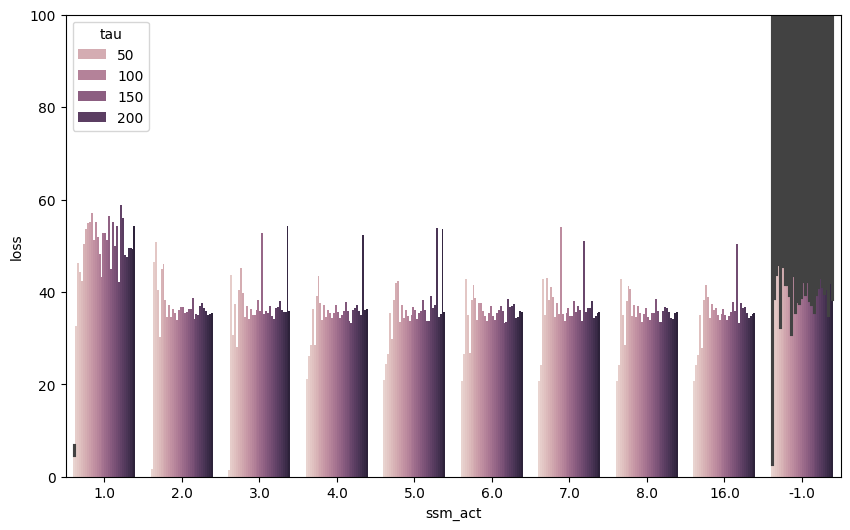

In [148]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x="ssm_act", y="loss", order=sorted(df["a"].unique())[1:] + [-1], hue="tau")
ax.set_ylim(0, 100)